In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc 
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
from jax import config
config.update("jax_enable_x64", True)

# Fringes

In [3]:
def fringes(gamma, scale_factor = 1):
    N = 40
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])
    cd_length = 2*jnp.sqrt(jnp.pi)*scale_factor
    gamma = scale_factor * gamma
    cirq.append(jqtc.CD(N, cd_length), [0,1])
    # cirq.append(jqtc.X(), 0)
    cirq.append(jqtc.D(N, 1j*gamma), 1)
    cirq.append(jqtc.CD(N, -cd_length), [0,1])
    # cirq.append(jqtc.X(), 0)
    cirq.append(jqtc.D(N, -1j*gamma), 1)
    
    plus_state = (jqt.basis(2,0) + jqt.basis(2,1))/jnp.sqrt(2)
    
    initial_state = plus_state ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state)
    final_state = res[-1][-1]
    
    sigma_x_op = jqt.sigmax() ^ jqt.identity(N)
    sigma_x_ep = final_state.dag() @ sigma_x_op @ final_state
    return sigma_x_ep.data[0][0].real

fringes_vmap = vmap(lambda g: fringes(g, scale_factor=1))

In [13]:
2*jnp.sqrt(jnp.pi)*jnp.sqrt(jnp.pi)/2

Array(3.14159265, dtype=float64, weak_type=True)

In [6]:
# gammas = jnp.linspace(-0.04*77, 0.04*77, 101)
gammas =  jnp.sqrt(jnp.pi)  * jnp.linspace(-2, 2, 1001)
sigmax_vals = fringes_vmap(gammas)

In [12]:
jnp.pi/(0.5*jnp.sqrt(jnp.pi)) - 2*jnp.sqrt(jnp.pi)

Array(4.4408921e-16, dtype=float64, weak_type=True)

Text(0.5, 1.0, 'Fringes without Interleaved Pi Pulses')

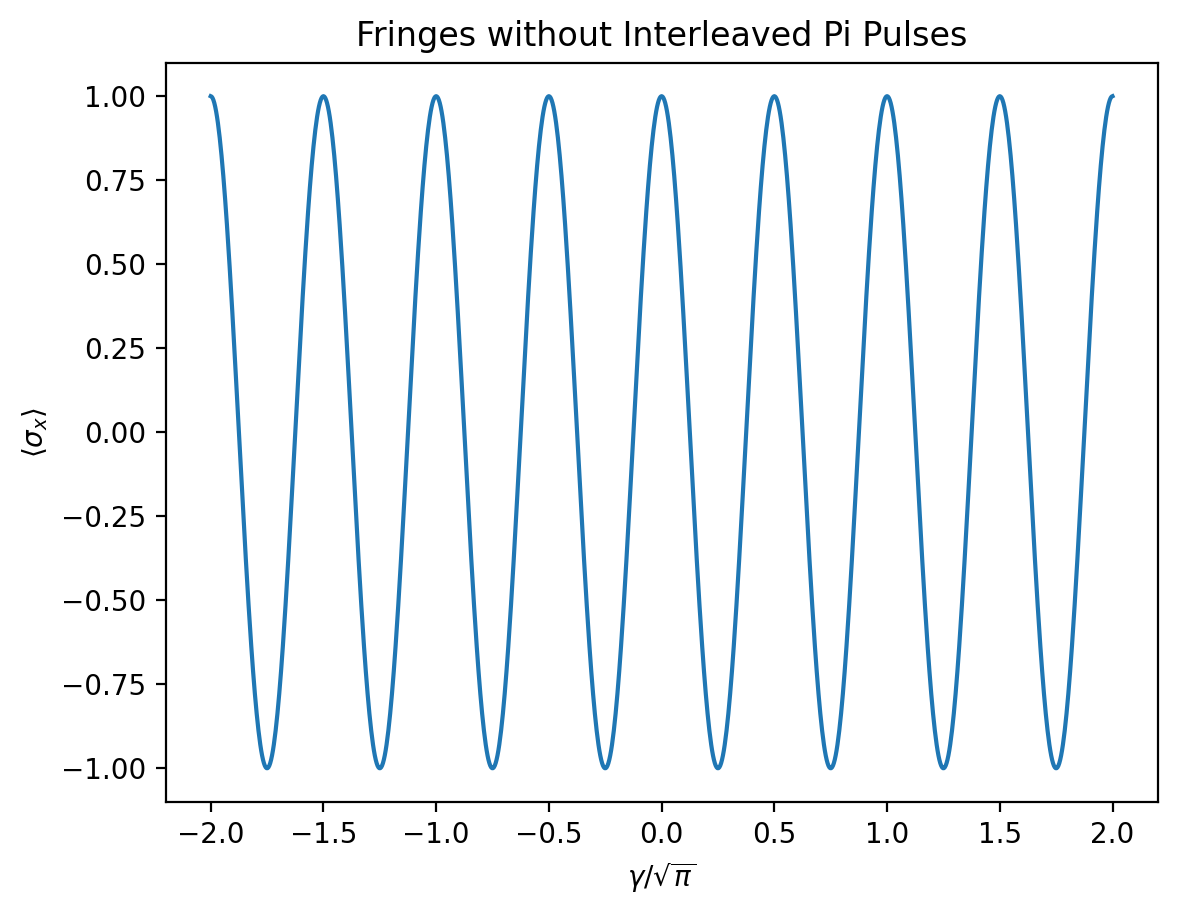

In [9]:
fig, ax = plt.subplots(1,1, dpi=200)

ax.plot(gammas/(jnp.sqrt(jnp.pi)), sigmax_vals)
ax.set_xlabel(r'$\gamma/\sqrt{\pi}$')
ax.set_ylabel(r'$\langle \sigma_x \rangle$')
ax.set_title('Fringes without Interleaved Pi Pulses')

Array(0.99231879, dtype=float64, weak_type=True)

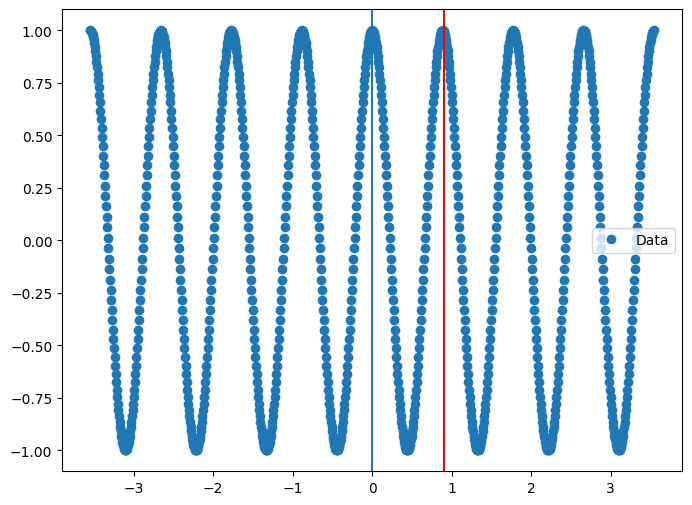

In [48]:
from scipy.optimize import curve_fit

y = sigmax_vals 
x = gammas 

# Define the cosine function to fit
def cosine_func(x, A, B, C):
    return A * jnp.cos(B * x + C)

fig, ax = plt.subplots(1,1, figsize=(8,6))

# Plot the fitted curve
ax.plot(x, y, "o", label='Data')
vs = [0.0, 0.9]
ax.axvline(vs[0])
ax.axvline(vs[1], color="red")
ax.legend()


cd_beta_prop = 2*jnp.sqrt(jnp.pi)
d_alpha_prop = vs[1]-vs[0]

jnp.sqrt((jnp.pi)/(cd_beta_prop*d_alpha_prop))

# CF Tomography

In [1]:
def cf_tomography_circuit(state, beta):
    N = state.dims[0][1]
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    cirq.append(jqtc.H(), 0)
    cirq.append(jqtc.CD(N, beta), [0,1])
    cirq.append(jqtc.H(), 0)
    res = jqtc.simulate(cirq, state)
    final_state = res[-1][-1]
    sigmaz = jqt.sigmaz() ^ jqt.identity(N)
    sigmaz_exp = final_state.dag() @ sigmaz @ final_state
    return sigmaz_exp.data[0][0].real

### MM Plots

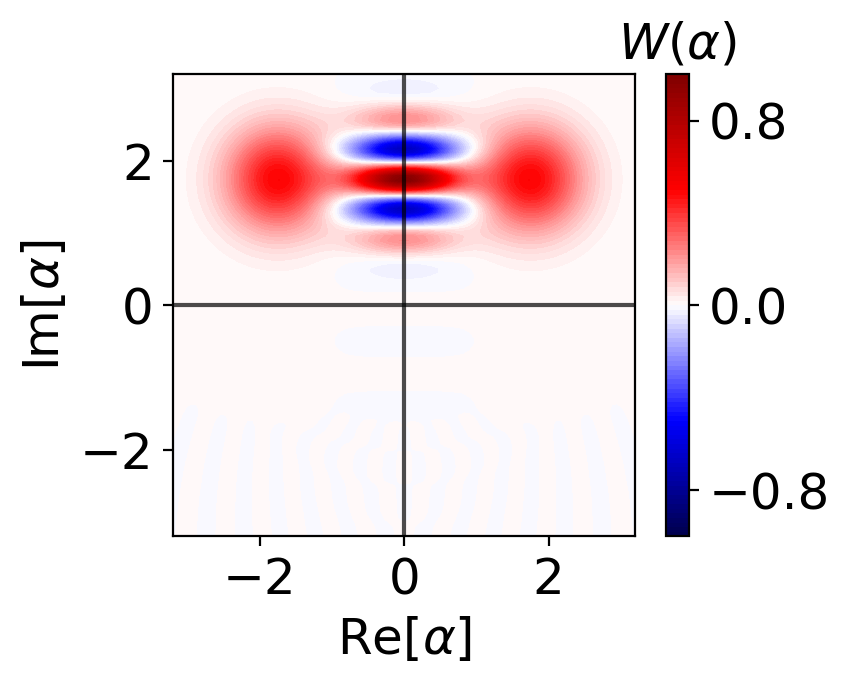

In [18]:
# State Prep
N = 40

# osc_state = jqt.displace(N, -1 + 1j) @ jqt.basis(N, 0)

# Displaced Cat
alpha = 1.75
p_alpha = (jqt.displace(N, alpha) @ jqt.basis(N,0)) 
m_alpha = (jqt.displace(N, -alpha) @ jqt.basis(N,0))
osc_state = (p_alpha + m_alpha).unit()
osc_state = (jqt.displace(N,1.75j)) @ osc_state

# Plot Wigner
pts = jnp.linspace(-3.2,3.2,101)
jqt.plot_wigner(osc_state, pts)
ax = plt.gca()
ax.set_xticks([-2,0,2])
ax.set_yticks([-2,0,2])
ax.tick_params(labelsize=18)

cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.ax.set_title(r'$W(\alpha)$', fontsize=18)
cbar.ax.set_yticks([-0.8, 0, 0.8])
cbar.ax.tick_params(labelsize=18)

ax.grid(False)

ax.set_xlabel(r'Re[$\alpha$]', fontsize=18)
ax.set_ylabel(r'Im[$\alpha$]', fontsize=18)
plt.show()

In [19]:
state = jqt.basis(2,0) ^ osc_state

# Plot CF

betas_im = jnp.linspace(-2.2, 2.2, 101)
betas_re = jnp.linspace(-2.2, 2.2, 101)
betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
betas_flat = betas.flatten()

cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta)))
tomo_res = cf_tomography_circuit_vmap(betas_flat)
tomo_res = tomo_res.reshape(*betas.shape)

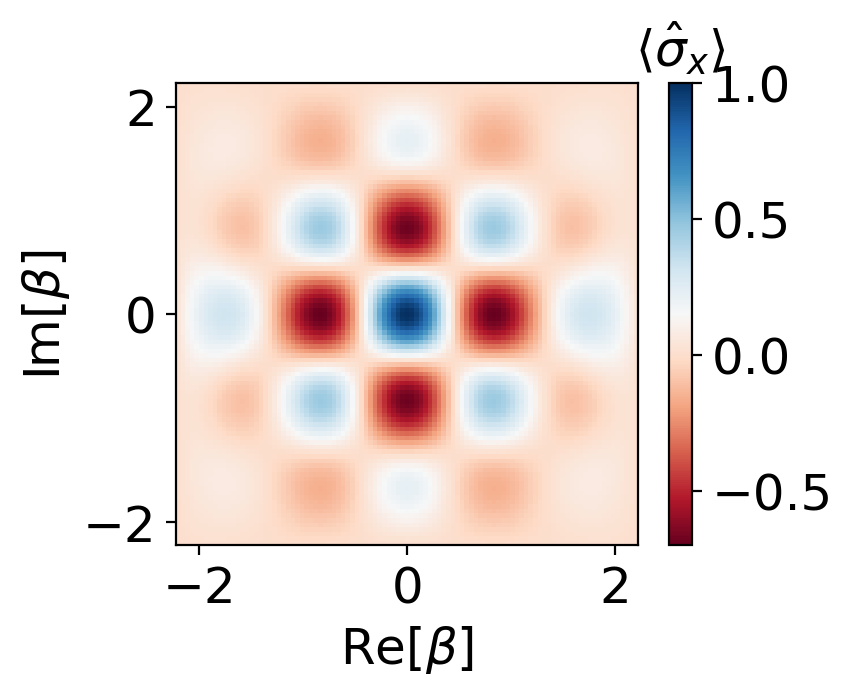

In [20]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
ax.pcolormesh(betas_re, betas_im, tomo_res.T, cmap='RdBu')

ax.set_xlabel(r'Re[$\beta$]', fontsize=18)
ax.set_ylabel(r'Im[$\beta$]', fontsize=18)
ax.set_xticks([-2,0,2])
ax.set_yticks([-2,0,2])
ax.tick_params(labelsize=18)

ax.set
ax.grid(False)
# ax.set_title('Characteristic Function Tomography')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.ax.set_title(r'$\langle \hat{\sigma}_x \rangle$', fontsize=18)
cbar.ax.set_yticks([-0.5, 0, 0.5, 1])
cbar.ax.tick_params(labelsize=18)

ax.set_aspect('equal')


2.3122121930420878e-08


Text(0, 0.5, '$\\dot{x}_e - \\dot{x}_g$')

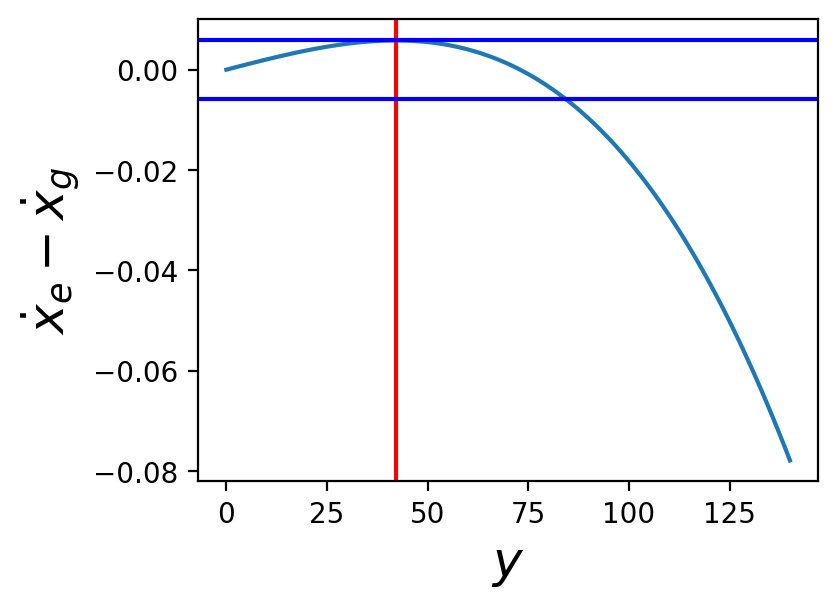

In [41]:
chi = 2*jnp.pi*33e-6
K = 2*jnp.pi*3.68e-9
chi_prime = 2*jnp.pi*3.1e-9
Kg = K         # Kerr nonlinearity in ground
Ke = K - chi_prime 

print(Kg)
yvals = jnp.linspace(0,140,101)
maxy = jnp.sqrt(chi/(6*(Kg - Ke)))
sep_f = lambda y : (chi - 2*(Kg - Ke)*y**2)*y
sep_vals = sep_f(yvals)

fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
ax.plot(yvals, sep_vals)
ax.axvline(maxy, color='red')
ax.axhline(sep_f(maxy), color='blue')
ax.axhline(-sep_f(maxy), color='blue')
ax.set_xlabel(r'$y$', fontsize=18)
ax.set_ylabel(r'$\dot{x}_e - \dot{x}_g$', fontsize=18)


## Coherent State

In [ ]:
N = 40
alpha = -1
p_alpha = jqt.basis(2,0) ^ (jqt.displace(N, alpha) @ jqt.basis(N,0)) 
m_alpha = jqt.basis(2,0) ^ (jqt.displace(N, -alpha) @ jqt.basis(N,0))
# state = jqt.basis(2,0) ^ jqt.basis(N,0)
state = p_alpha
state = (jqt.identity(2) ^ jqt.displace(N,1j)) @ state

Text(0.5, 1.0, 'Wigner Function of Coherent State')

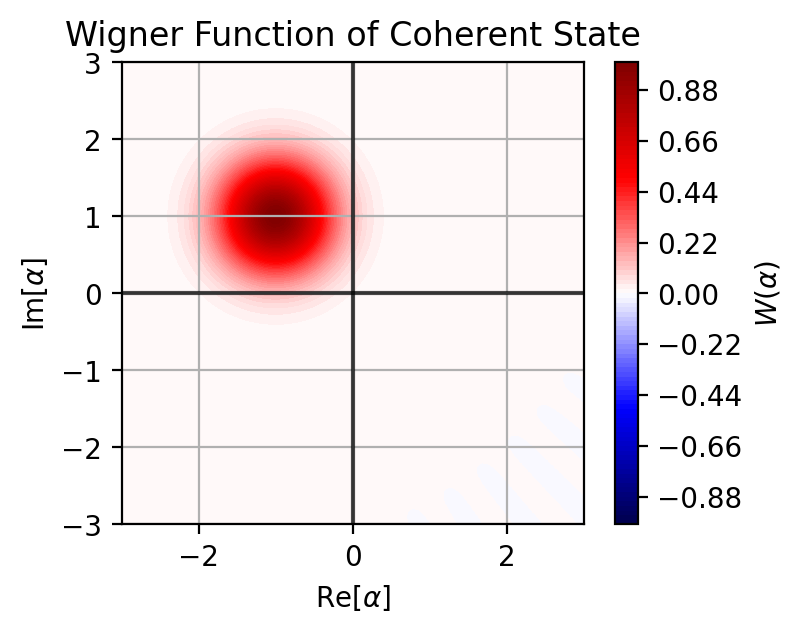

In [27]:
pts = jnp.linspace(-3,3,101)
jqt.plot_wigner(state, pts)
ax = plt.gca()
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label(r'$W(\alpha)$')
ax.set_xlabel(r'Re[$\alpha$]')
ax.set_ylabel(r'Im[$\alpha$]')
ax.set_title(r'Wigner Function of Coherent State')

In [ ]:
betas_im = jnp.linspace(-3, 3, 101)
betas_re = jnp.linspace(-3, 3, 101)
betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
betas_flat = betas.flatten()

cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta)))
tomo_res = cf_tomography_circuit_vmap(betas_flat)
tomo_res = tomo_res.reshape(*betas.shape)

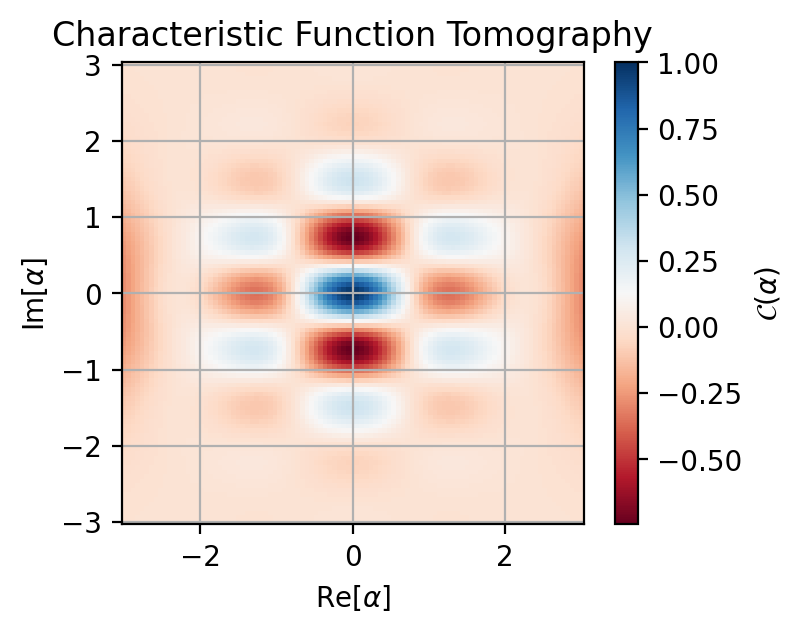

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
ax.pcolormesh(betas_re, betas_im, tomo_res.T, cmap='RdBu')

ax.set_xlabel(r'Re[$\alpha$]')
ax.set_ylabel(r'Im[$\alpha$]')
ax.grid(True)
ax.set_title('Characteristic Function Tomography')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label(r'$\mathcal{C}(\alpha)$')
ax.set_aspect('equal')

## Cat State

In [4]:
N = 40
alpha = 2
p_alpha = jqt.basis(2,0) ^ (jqt.displace(N, alpha) @ jqt.basis(N,0)) 
m_alpha = jqt.basis(2,0) ^ (jqt.displace(N, -alpha) @ jqt.basis(N,0))
state = (p_alpha - m_alpha).unit()
state = (jqt.identity(2) ^ jqt.displace(N,1j)) @ state

Text(0.5, 1.0, 'Wigner Function of Displaced Cat')

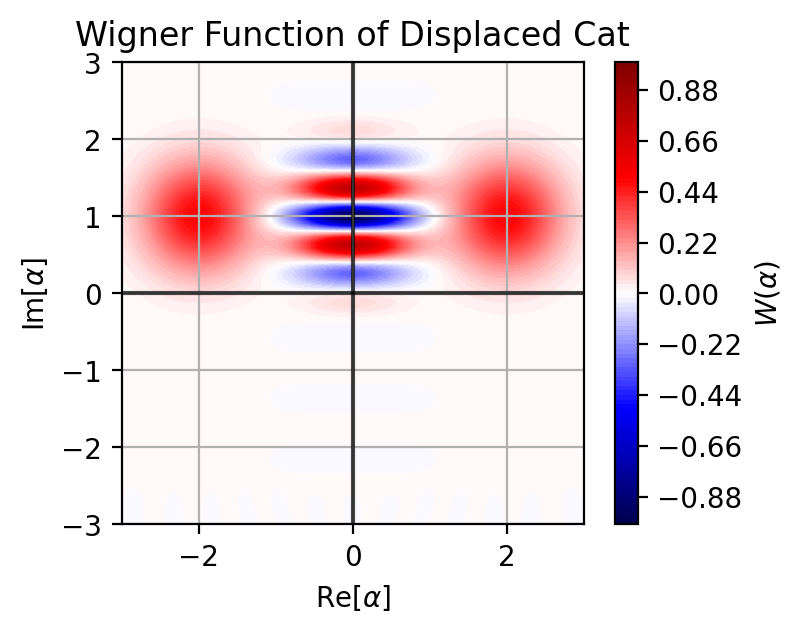

In [5]:
pts = jnp.linspace(-3,3,101)
jqt.plot_wigner(state, pts)
ax = plt.gca()
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label(r'$W(\alpha)$')
ax.set_xlabel(r'Re[$\alpha$]')
ax.set_ylabel(r'Im[$\alpha$]')
ax.set_title(r'Wigner Function of Displaced Cat')

In [6]:
betas_im = jnp.linspace(-3, 3, 101)
betas_re = jnp.linspace(-3, 3, 101)
betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
betas_flat = betas.flatten()

cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta)))
tomo_res = cf_tomography_circuit_vmap(betas_flat)
tomo_res = tomo_res.reshape(*betas.shape)

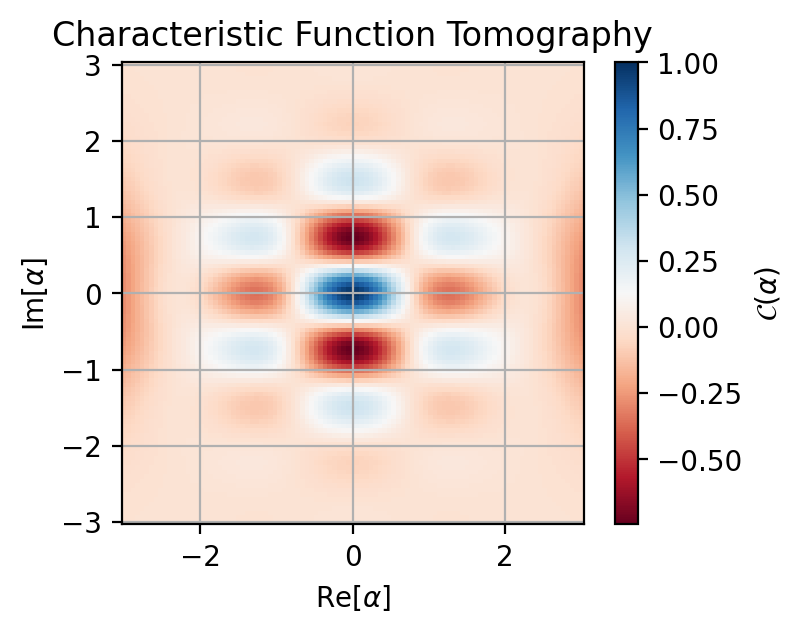

In [7]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
ax.pcolormesh(betas_re, betas_im, tomo_res.T, cmap='RdBu')

ax.set_xlabel(r'Re[$\alpha$]')
ax.set_ylabel(r'Im[$\alpha$]')
ax.grid(True)
ax.set_title('Characteristic Function Tomography')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label(r'$\mathcal{C}(\alpha)$')
ax.set_aspect('equal')

# Classically mixed state

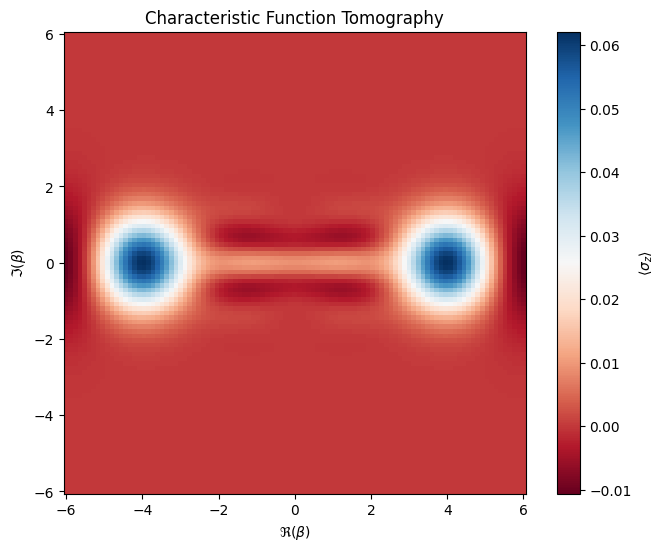

In [23]:
betas_im = jnp.linspace(-6, 6, 101)
betas_re = jnp.linspace(-6, 6, 101)
betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
betas_flat = betas.flatten()

p_alpha = jqt.basis(2,0) ^ (jqt.displace(N, alpha) @ jqt.basis(N,0)) 
m_alpha = jqt.basis(2,0) ^ (jqt.displace(N, -alpha) @ jqt.basis(N,0))

state = (p_alpha.to_dm() + m_alpha.to_dm()).unit()

cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta)))
tomo_res = cf_tomography_circuit_vmap(betas_flat)
tomo_res = tomo_res.reshape(*betas.shape)

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.pcolormesh(betas_re, betas_im, tomo_res.T, cmap='RdBu')
ax.set_xlabel(r'$\Re(\beta)$')
ax.set_ylabel(r'$\Im(\beta)$')
ax.set_title('Characteristic Function Tomography')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label(r'$\langle \sigma_z \rangle$')
ax.set_aspect('equal')

## Vacuum state

/var/folders/8l/p0d82y553g145f5xw3p4l60h0000gn/T/ipykernel_87016/2729806791.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, betas, tomo_res)


Text(0.5, 1.0, 'CF Tomography of a vacuum oscillator state')

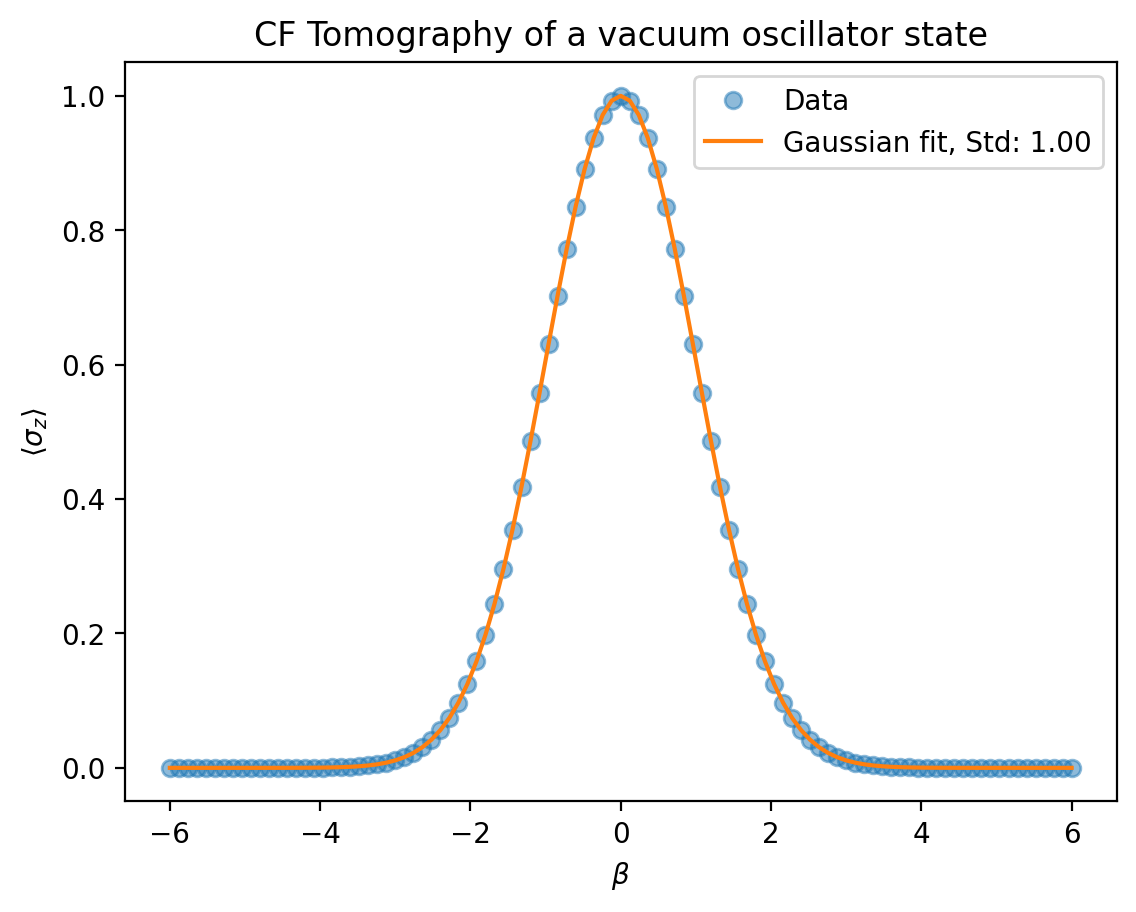

In [25]:
from scipy.optimize import curve_fit

betas  = jnp.linspace(-6,6,101)
state = jqt.basis(2,0) ^ osc_state
cf_tomography_circuit_vmap = vmap(lambda beta: cf_tomography_circuit(state, beta))
tomo_res = cf_tomography_circuit_vmap(betas)

# Define the Gaussian function to fit
def gaussian(x, a, x0, sigma):
    return a * jnp.exp(-(x - x0)**2 / (2 * sigma**2))

# Fit the Gaussian function to the data
popt, pcov = curve_fit(gaussian, betas, tomo_res)


fig, ax = plt.subplots(1,1, dpi=200)
ax.plot(betas, tomo_res, "o", alpha=0.5, label='Data')
ax.plot(betas, gaussian(betas, *popt), label='Gaussian fit, Std: {:.2f}'.format(popt[2]))
ax.legend()
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\langle \sigma_z \rangle$')
ax.set_title('CF Tomography of a vacuum oscillator state')

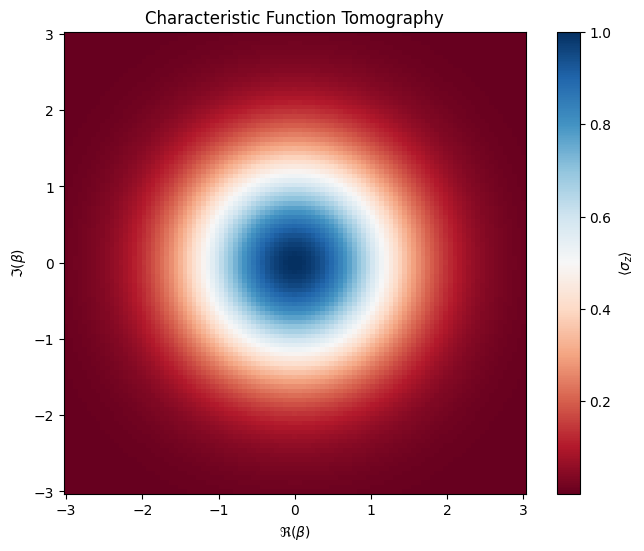

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.pcolormesh(betas_re, betas_im, tomo_res.T, cmap='RdBu')
ax.set_xlabel(r'$\Re(\beta)$')
ax.set_ylabel(r'$\Im(\beta)$')
ax.set_title('Characteristic Function Tomography')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label(r'$\langle \sigma_z \rangle$')
ax.set_aspect('equal')
